# Monte Carlo Simulations in Financial Derivative Pricing

Monte Carlo simulation has become a cornerstone of quantitative finance, particularly in the valuation of financial derivatives. This paper explores its theoretical foundations, practical applications, and computational considerations. The mathematical framework and examples presented herein draw heavily from *Implementing Derivative Models* by Les Clewlow and Chris Strickland.


## Introduction

The valuation of financial derivatives often requires complex mathematical tools, especially when analytical solutions are unavailable. Monte Carlo simulation provides a powerful, flexible approach to tackle these problems by relying on probabilistic methods. The core idea involves simulating a large number of possible outcomes for a stochastic process, which allows us to compute key statistical measures such as expectations, variances, and probabilities.

The framework for pricing derivatives using Monte Carlo simulations is underpinned by the theory of risk-neutral pricing. This approach transforms real-world asset dynamics under the $P$-measure to a risk-neutral probability space ($\mathbb{Q}$-measure), enabling the use of discounted expected values to determine derivative prices. Mathematically, this is expressed as:

\[
\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{Q}}\left[\frac{C_T}{B_T} \mid F_t\right],
\]

where \( C_t \) represents the value of the derivative at time \( t \), \( B_t \) is the price of a risk-free asset, and \( \mathbb{E}_{\mathbb{Q}} \) denotes the expectation under the risk-neutral measure.


## Monte Carlo Simulation: An Overview

Monte Carlo methods solve probabilistic problems through numerical simulation of random scenarios. The method's flexibility makes it invaluable for pricing financial instruments, especially when no closed-form solution exists. Initially introduced to finance by Boyle (1977), Monte Carlo simulation has since been widely adopted due to its ability to model complex, multidimensional stochastic processes.

### Applications in Finance

Monte Carlo simulation serves various purposes in financial mathematics:

1. **Portfolio Analysis under the Real-World Probability Measure ($P$):**
   - Computing expected returns.
   - Estimating risk metrics such as Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR).
   - Quantifying downside risks, including drawdowns.

2. **Derivative Pricing under the Risk-Neutral Measure ($\mathbb{Q}$):**
   - Calculating the risk-neutral expectation of discounted payoffs for financial derivatives.
   - Simulating complex asset dynamics, such as those with jumps or stochastic volatility.


## Valuation of Derivatives via Simulation

The risk-neutral valuation principle asserts that the price of a derivative is equal to the risk-neutral expectation of its discounted payoff:

\[
C_0 = \mathbb{E}_{\mathbb{Q}}\left[\exp\left(-\int_0^T r_s \, ds\right) C_T\right].
\]

In a discrete setting, the discount factor simplifies to \( \exp(-rT) \) for constant interest rates. For a single simulation \( i \), the discounted payoff is:

\[
C_{0,i} = \exp(-rT) C_{T,i}.
\]

Repeating this simulation \( M \) times yields an estimate of the option value as the average of all simulated outcomes:

\[
\hat{C_0} = \frac{1}{M} \sum_{i=1}^M C_{0,i}.
\]

### Error Quantification

The estimate \( \hat{C_0} \) contains sampling error, as it relies on a finite number of simulations. This error is measured by the **standard error**, defined as:

\[
SE(\hat{C_0}) = \frac{\sigma(C_{0,i})}{\sqrt{M}},
\]

where \( \sigma(C_{0,i}) \) is the standard deviation of the individual simulated payoffs, calculated as:

\[
\sigma(C_{0,i}) = \sqrt{\frac{1}{M-1} \sum_{i=1}^M (C_{0,i} - \hat{C_0})^2}.
\]


## Case Study: European Call Option Pricing in the Black-Scholes Framework

The Black-Scholes model assumes that stock prices follow a **Geometric Brownian Motion (GBM)**:

\[
dS_t = rS_t \, dt + \sigma S_t \, dW_t,
\]

where \( S_t \) is the stock price, \( r \) is the risk-free rate, \( \sigma \) is the volatility, and \( W_t \) is a standard Brownian motion.

### Logarithmic Transformation

To simulate this process, it is convenient to work with the natural logarithm of the stock price, \( x_t = \ln(S_t) \), whose dynamics are given by:

\[
dx_t = \nu \, dt + \sigma \, dz_t, \quad \nu = r - \frac{1}{2}\sigma^2,
\]

where \( \nu \) represents the drift of the log-price, and \( z_t \) is a standard Brownian motion.

### Discretization of the Stochastic Differential Equation

The stochastic differential equation (SDE) can be discretized to approximate \( x_t \) over small time intervals \( \Delta t \):

\[
\Delta x = \nu \, \Delta t + \sigma \, \Delta z.
\]

The exact solution is expressed as:

\[
x_{t+\Delta t} = x_t + \nu \, \Delta t + \sigma \, (z_{t+\Delta t} - z_t),
\]

where \( z_{t+\Delta t} - z_t \sim \mathcal{N}(0, \Delta t) \). 

In terms of the original stock price \( S_t \), the solution becomes:

\[
S_{t+\Delta t} = S_t \exp\left(\nu \Delta t + \sigma \sqrt{\Delta t} \epsilon_i\right),
\]

with \( \epsilon_i \sim \mathcal{N}(0,1) \).


## Computational Efficiency and Variance Reduction

Although Monte Carlo simulation is a versatile tool, it is computationally expensive compared to analytical methods like the Black-Scholes formula. To address this inefficiency, several techniques are commonly employed:

1. **Variance Reduction Methods:**
   - **Antithetic Variates:** Use negatively correlated random variables to reduce variance.
   - **Control Variates:** Exploit the correlation between the simulated quantity and a known quantity with an exact expectation.

2. **Quasi-Random Sequences:**
   - Replace pseudo-random numbers with deterministic low-discrepancy sequences to improve convergence.

These methods will be explored in future work.

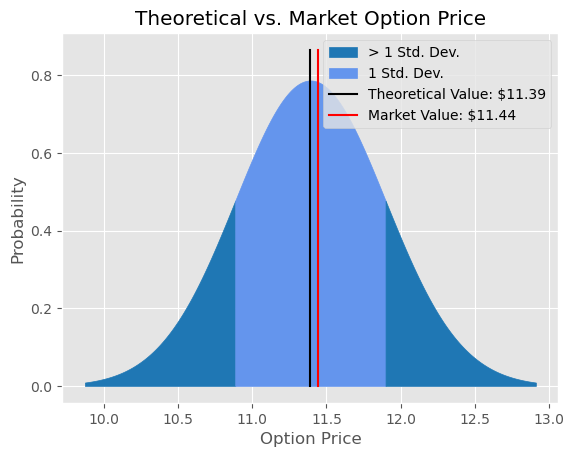

In [1]:
## Code Implementation: Monte Carlo Simulation for European Call Option Pricing

# Import necessary libraries
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

# Use a clean plotting style for better visualization
plt.style.use('ggplot')

# Define initial parameters for the derivative
S = 606.76            # Current stock price
K = 607               # Strike price of the option
vol = 0.113           # Volatility of the stock (annualized)
r = 0.0443            # Risk-free interest rate (annualized)
N = 10                # Number of time steps in the simulation
M = 1000              # Number of Monte Carlo simulations
market_value = 11.44  # Observed market price of the option

# Time to maturity (in years)
T = ((datetime.date(2025, 1, 31) - datetime.date(2024, 12, 17)).days + 1) / 365  

# Precompute constants to improve efficiency
dt = T / N                      # Time step size
nudt = (r - 0.5 * vol**2) * dt  # Drift component
volsdt = vol * np.sqrt(dt)      # Diffusion component
lnS = np.log(S)                 # Natural logarithm of the initial stock price

# Step 1: Generate stochastic price paths using GBM
# Generate random normal variables for the simulation
Z = np.random.normal(size=(N, M))  # Shape: (time steps, number of simulations)

# Compute the changes in the log stock price for each step
delta_lnSt = nudt + volsdt * Z

# Cumulatively sum these changes to simulate the log stock price paths
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)

# Prepend the initial stock price to all paths for consistency
lnSt = np.concatenate((np.full(shape=(1, M), fill_value=lnS), lnSt))

# Step 2: Compute the stock prices from the simulated log prices
ST = np.exp(lnSt)  # Stock prices at each step

# Step 3: Calculate the payoff for a European call option
CT = np.maximum(0, ST - K)  # Payoff at maturity: max(0, ST - K)

# Step 4: Estimate the theoretical option price and its standard error
C0 = np.exp(-r * T) * np.sum(CT[-1]) / M  # Discounted average payoff

# Calculate the standard error of the estimated price
sigma = np.sqrt(np.sum((CT[-1] - C0)**2) / (M - 1))  # Sample standard deviation
SE = sigma / np.sqrt(M)  # Standard error

# Step 5: Visualize the theoretical price and uncertainty
# Define regions for standard deviations
x1 = np.linspace(C0 - 3 * SE, C0 - 1 * SE, 100)
x2 = np.linspace(C0 - 1 * SE, C0 + 1 * SE, 100)
x3 = np.linspace(C0 + 1 * SE, C0 + 3 * SE, 100)

# Compute probability densities
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

# Plot the regions and theoretical vs. market prices
plt.fill_between(x1, s1, color='tab:blue', label='> 1 Std. Dev.')
plt.fill_between(x2, s2, color='cornflowerblue', label='1 Std. Dev.')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0, C0], [0, max(s2) * 1.1], 'k', 
         label=f'Theoretical Value: ${np.round(C0, 2)}')
plt.plot([market_value, market_value], [0, max(s2) * 1.1], 'r', 
         label=f'Market Value: ${np.round(market_value, 2)}')

# Add labels, legend, and title for the plot
plt.title("Theoretical vs. Market Option Price")
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()

## Results and Interpretation
The theoretical value of the option is ≈C0, as estimated through Monte Carlo simulation. The plot highlights the uncertainty around this estimate and allows comparison with the observed market price (\approx \text{market_value}). Variance reduction techniques, such as antithetic variates or control variates, can further improve accuracy and reduce computational cost.

## Conclusion

Monte Carlo simulation is an indispensable tool in modern quantitative finance, particularly for pricing complex derivatives and analyzing portfolio risks. While computationally intensive, its flexibility makes it uniquely suited to problems that resist closed-form solutions. By leveraging advanced techniques such as variance reduction and quasi-random sequences, we can enhance the efficiency and accuracy of Monte Carlo methods, broadening their applicability in financial mathematics.

## References

- Clewlow, L., & Strickland, C. (1998). *Implementing Derivative Models*. Wiley.
- Boyle, P. P. (1977). Options: A Monte Carlo Approach. *Journal of Financial Economics*.